# VIME: Self/Semi Supervised Learning for Tabular Data

# Setup

In [8]:
import sys
sys.path.append('../')

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import umap
from sklearn.metrics import (average_precision_score, mean_squared_error,
                             roc_auc_score)
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from vime.vime import VIME, VIME_Self
from vime.vime_data import (
    labelled_loss_fn, mask_generator_tf,
    pretext_generator_tf, semi_supervised_generator,
    to_vime_dataset, unlabelled_loss_fn
)

In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = (20,10)

# Data

The example data is taken from [Kaggle](https://www.kaggle.com/c/ieee-fraud-detection) but it's already pre-processed and ready to be used. You can checkout the pre-processing notebook in the same folder to get some understanding about what transformations were done to the features.

In [11]:
train = pd.read_csv("../data/fraud_train_preprocessed.csv")
test = pd.read_csv("../data/fraud_test_preprocessed.csv")

In [12]:
# Drop nan columns as they are not useful for reconstruction error
nan_columns = [f for f in train.columns if 'nan' in f]
train = train.drop(nan_columns, axis=1)
test = test.drop(nan_columns, axis=1)

In [13]:
# Also, using only numerical columns because NNs have issue with one-hot encoding 
num_cols = train.columns[:-125]

In [14]:
# Validation size is 10%
val_size = int(train.shape[0] * 0.1)
X_train = train.iloc[:-val_size, :]
X_val = train.iloc[-val_size:, :]

# Labelled 1% of data, everything else is unlabelled
X_train_labelled = train.sample(frac=0.01)
y_train_labelled = X_train_labelled.pop('isFraud')

X_val_labelled = X_val.sample(frac=0.01)
y_val_labelled = X_val_labelled.pop('isFraud')

X_train_unlabelled = X_train.loc[~X_train.index.isin(X_train_labelled.index), :].drop('isFraud', axis=1)
X_val_unlabelled = X_val.loc[~X_val.index.isin(X_val_labelled.index), :].drop('isFraud', axis=1)

In [15]:
X_train_labelled = X_train_labelled[num_cols]
X_val_labelled = X_val_labelled[num_cols]

X_train_unlabelled = X_train_unlabelled[num_cols]
X_val_unlabelled = X_val_unlabelled[num_cols]

In [16]:
X_val_labelled.shape, X_train_labelled.shape

((531, 110), (5315, 110))

In [17]:
print("Labelled Fraudsters", y_train_labelled.sum())

print(
    "Labelled Proportion:", 
    np.round(X_train_labelled.shape[0] / (X_train_unlabelled.shape[0] + X_train_labelled.shape[0]), 5)
)

Labelled Fraudsters 176.0
Labelled Proportion: 0.0111


The following model will be trained with these hyperparameters:

In [241]:
vime_params = {
    'alpha': 4, 
    'beta': 10, 
    'k': 5, 
    'p_m': 0.36
}

## Self-Supervised Learning

### Data Prep

The model needs 1 input - corrupted X, and 2 outputs - mask and original X. 

In [249]:
batch_size = 1024

# Datasets
train_ds, train_m = to_vime_dataset(X_train_unlabelled, vime_params['p_m'], batch_size=batch_size, shuffle=True)
val_ds, val_m = to_vime_dataset(X_val_unlabelled, vime_params['p_m'], batch_size=batch_size)
num_features = X_train_unlabelled.shape[1]

print('Proportion Corrupted:', np.round(train_m.numpy().mean(), 2))

# Training
vime_s = VIME_Self(num_features)
vime_s.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={
        'mask': 'binary_crossentropy', 
        'feature': 'mean_squared_error'},
    loss_weights={'mask':1, 'feature': vime_params['alpha']}
)

cbs = [tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )]

vime_s.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000,
    callbacks=cbs
)

vime_s.save('./vime_self')

In [193]:
vime_s = tf.keras.models.load_model('./vime_self')

### Evaluation

All the evaluation will be done on the validation set

In [149]:
val_self_preds = vime_s.predict(val_ds)

To evaluate the mask reconstruction ability we can simply check the ROC AUC score for mask predictions across all the features. 

In [203]:
feature_aucs = []
for i in tqdm(range(X_val_unlabelled.shape[1])):
    roc = roc_auc_score(val_m.numpy()[:, i], val_self_preds['mask'][:, i])
    feature_aucs.append(roc)

100%|██████████| 110/110 [00:02<00:00, 49.70it/s]


In [206]:
self_metrics = pd.DataFrame({"metric": 'mask_auc', 
             "metric_values": feature_aucs})

Now, we can evaluate the feature reconstruction ability using RMSE and correlation coefficients

In [209]:
feature_corrs = []
for i in tqdm(range(X_val_unlabelled.shape[1])):
    c = np.corrcoef(X_val_unlabelled.values[:, i], val_self_preds['feature'][:, i])[0, 1]
    feature_corrs.append(c)
    
self_metrics = pd.concat([
    self_metrics,
    pd.DataFrame({"metric": 'feature_correlation', 
             "metric_values": feature_corrs})
])

From the plot and table above, we can see that the model has learned to reconstruct most of the features. Half of the features are reconstructed with relatively strong correlation with original data. Only a handful of features are not properly reconstructed. Let's check the RMSE across all the features

In [211]:
rmses = []
for i in tqdm(range(X_val_unlabelled.shape[1])):
    mse = mean_squared_error(X_val_unlabelled.values[:, i], val_self_preds['feature'][:, i])
    rmses.append(np.sqrt(mse))
    
self_metrics = pd.concat([
    self_metrics,
    pd.DataFrame({"metric": 'RMSE', 
             "metric_values": rmses})
])

Text(0.5, 1.0, 'Self-Supervised VIME Evaluation')

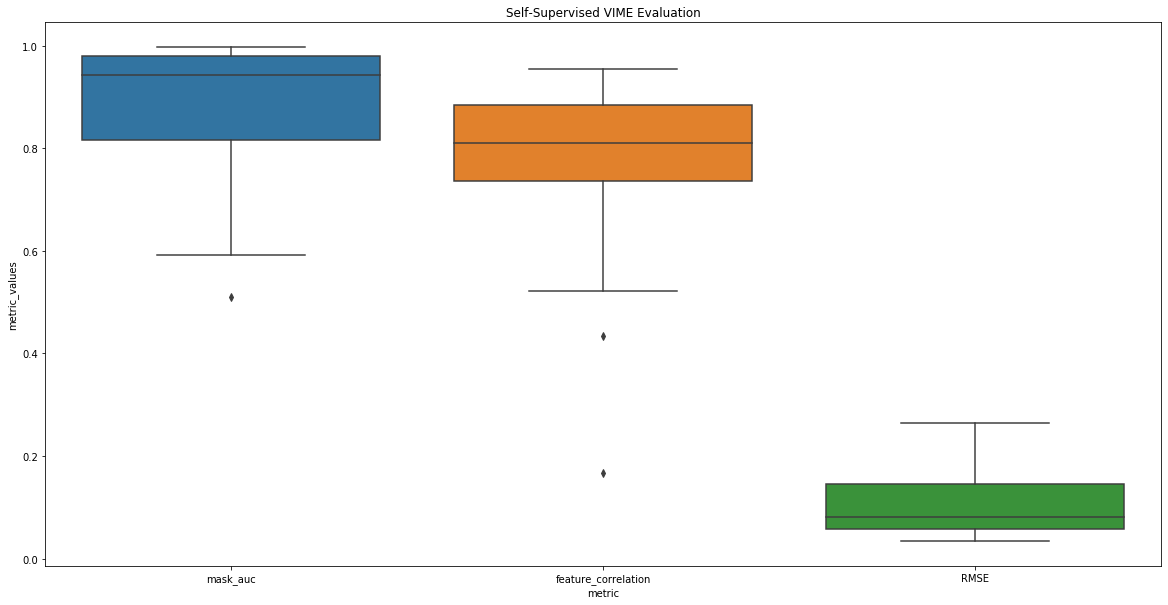

In [216]:
sns.boxplot(x=self_metrics['metric'], y=self_metrics['metric_values'])
plt.title("Self-Supervised VIME Evaluation")

RMSE distribution further indicates that mjority of the features are well-reconstructed.

Another way to evaluate the self-supervised model is to look at the embeddings. Since the whole point of corrupting the dataset is to learn to generate robust embeddings, we can assume that if a sample was corrupted 5 times, all 5 embeddings should be relatively close to each other in the vector space. Let's check this hypothesis by corrupting 10 different samples 5 times and projecting their embeddings to 2-dimensional space using UMAP.

In [157]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout


def generate_k_corrupted(x, k, p_m):
    x_u_list = []
    for i in range(k):
        mask = mask_generator_tf(p_m, x)
        _, x_corr = pretext_generator_tf(mask, tf.constant(x, dtype=tf.float32))
        x_u_list.append(x_corr)
    
    
    # Prepare input with shape (n, k, d)
    x_u_corrupted = np.zeros((x.shape[0], k, x.shape[1]))
    for i in range(x.shape[0]):
        for j in range(k):
            x_u_corrupted[i, j, :] = x_u_list[j][i, :]
    
    return x_u_corrupted

In [200]:
vime_s = tf.keras.models.load_model('./vime_self')

# Sequential model to produce embeddings
encoding_model = Sequential(
    [
        Input(num_features),
        vime_s.encoder
    ]
)

dense_model = Sequential(
    [
        Input(num_features),
        Dense(num_features, activation="relu"),
    
    ]
)

# Create corrupted sample
samples = X_val_unlabelled.sample(10)
sample_corrupted = generate_k_corrupted(
    x=samples,
    k=5,
    p_m=0.4
)

val_encoding = encoding_model.predict(sample_corrupted, batch_size=batch_size)
random_encoding = dense_model.predict(sample_corrupted, batch_size=batch_size)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
No handles with labels found to put in legend.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


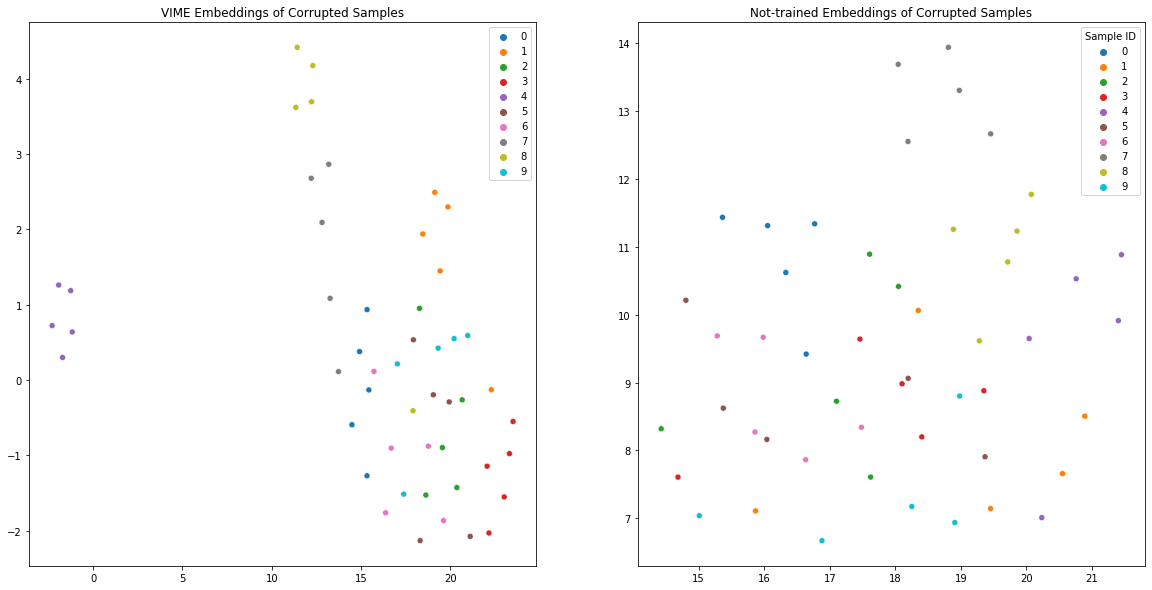

In [201]:
fig, axs = plt.subplots(1, 2)

# Project corrupted samples
u = umap.UMAP(n_neighbors=5, min_dist=0.8)
corrupted_umap = u.fit_transform(val_encoding.reshape(-1, val_encoding.shape[2]))
sample_ids = np.array([np.repeat(i, 5) for i in range(10)]).ravel()
sns.scatterplot(corrupted_umap[:, 0], corrupted_umap[:, 1], hue=sample_ids, palette="tab10", ax=axs[0])
axs[0].set_title('VIME Embeddings of Corrupted Samples')
plt.legend(title='Sample ID')

# Project corrupted samples
u = umap.UMAP(n_neighbors=5, min_dist=0.8)
corrupted_umap = u.fit_transform(random_encoding.reshape(-1, random_encoding.shape[2]))
sample_ids = np.array([np.repeat(i, 5) for i in range(10)]).ravel()
sns.scatterplot(corrupted_umap[:, 0], corrupted_umap[:, 1], hue=sample_ids, palette="tab10", ax=axs[1])
axs[1].set_title('Not-trained Embeddings of Corrupted Samples')

plt.legend(title='Sample ID')
plt.show()

As you can see, the embeddings indeed put the same samples closer to each other, even though some of their values were corrupted. According to the authors, this means that the model has learned useful information about the feature correlations which can be helpful in the downstream tasks. Now, we can use this encoder in the next semi-supervised part.

## Semi-Supervised Learning

In [244]:
semi_batch_size = 512
num_features = X_train_unlabelled.shape[1]

Since we have different number of labelled and unlabelled examples we need to use generators. They will shuffle and select appropriate number of rows for each training iteration.

In [162]:
def train_semi_generator():
    return semi_supervised_generator(
        X_train_labelled.values,
        X_train_unlabelled.values, 
        y_train_labelled.values, 
        bs=semi_batch_size
    )

def val_semi_generator():
    return semi_supervised_generator(
        X_val_labelled.values,
        X_val_unlabelled.values, 
        y_val_labelled.values, 
        bs=semi_batch_size
    )

semi_train_dataset = tf.data.Dataset.from_generator(
     train_semi_generator,
     output_signature=(
         tf.TensorSpec(shape=(semi_batch_size, num_features), dtype=tf.float32),
         tf.TensorSpec(shape=(semi_batch_size), dtype=tf.float32),
         tf.TensorSpec(shape=(semi_batch_size, num_features), dtype=tf.float32)
     )
)

semi_val_dataset = tf.data.Dataset.from_generator(
     val_semi_generator,
     output_signature=(
         tf.TensorSpec(shape=(semi_batch_size, num_features), dtype=tf.float32),
         tf.TensorSpec(shape=(semi_batch_size), dtype=tf.float32),
         tf.TensorSpec(shape=(semi_batch_size, num_features), dtype=tf.float32)
     )
)

## Self Supervised VIME

In [165]:
def train_vime_semi(encoder, train_dataset, val_dataset, train_params, vime_params):
    # Model
    vime = VIME(encoder)
    
    # Training parameters
    iterations = train_params['iterations']
    optimizer = tf.keras.optimizers.Adam(train_params['learning_rate'])
    early_stop = train_params['early_stop']
    
    # Set metrics to track
    best_loss = 1e10
    no_improve = 0
    
    # Begining training loop
    for it in range(iterations):
        # Grab a batch for iteration
        it_train = iter(train_dataset)
        X_l, y_l, X_u = next(it_train)
        
        # Generate unlabelled batch with k corrupted examples per sample
        X_u_corrupted = generate_k_corrupted(X_u, vime_params['k'], vime_params['p_m'])
        
        with tf.GradientTape() as tape:
            # Predict labelled & unlabelled
            labelled_preds = vime(X_l)
            unlabelled_preds = vime(X_u_corrupted)

            # Calculate losses
            labelled_loss = labelled_loss_fn(y_l, labelled_preds)
            unlabelled_loss = unlabelled_loss_fn(unlabelled_preds)

            # Total loss
            semi_supervised_loss = unlabelled_loss + vime_params['beta'] * labelled_loss
        
        if it % 10 == 0:
            val_iter_losses = []
            print(f"\nMetrics for Iteration {it}")
            for i in range(5):
                # Grab a batch
                it_val = iter(val_dataset)
                X_l_val, y_l_val, X_u_val = next(it_val)

                # Generate unlabelled batch with k corrupted examples per sample
                X_u_corrupted = generate_k_corrupted(X_u_val, vime_params['k'], vime_params['p_m'])

                # Predict labelled & unlabelled
                labelled_preds_val = vime(X_l_val)
                unlabelled_preds_val = vime(X_u_corrupted)

                # Calculate losses
                labelled_loss_val = labelled_loss_fn(y_l_val, labelled_preds_val)
                unlabelled_loss_val = unlabelled_loss_fn(unlabelled_preds_val)
                semi_supervised_loss_val = unlabelled_loss_val + vime_params['beta'] * labelled_loss_val
                val_iter_losses.append(semi_supervised_loss_val)
            
            # Average loss over 5 validation iterations
            semi_supervised_loss_val = np.mean(val_iter_losses)

            print(f"Train Loss {np.round(semi_supervised_loss, 5)}, Val Loss {np.round(semi_supervised_loss_val, 5)}")
            # Update metrics if val_loss is better
            if semi_supervised_loss_val < best_loss:
                best_loss = semi_supervised_loss_val
                no_improve = 0
                vime.save('./vime')
            else:
                no_improve += 1
                print(f"Validation loss not improved {no_improve} times")

            # Early stopping
            if no_improve == early_stop:
                break
        
        # Update weights
        grads = tape.gradient(semi_supervised_loss, vime.trainable_weights)
        optimizer.apply_gradients(zip(grads, vime.trainable_weights))

    vime = tf.keras.models.load_model('./vime')

    return vime

In [248]:
train_params = {
    'num_features': num_features,
    'iterations': 1000,
    'early_stop': 20,
    'learning_rate': 0.001
}

vime_self = tf.keras.models.load_model('./vime_self')

vime_semi = train_vime_semi(
    encoder = vime_self.encoder,
    train_dataset = semi_train_dataset, 
    val_dataset = semi_val_dataset,
    train_params = train_params,
    vime_params = vime_params
)


In [220]:
test_ds = tf.data.Dataset.from_tensor_slices(test[num_cols]).batch(batch_size)

vime_tuned_preds = vime_semi.predict(test_ds)
pr = average_precision_score(test['isFraud'], vime_tuned_preds)
print(pr)

0.38815360485173106


## Evaluation

Re-training the model 10 times to get distribution of PR AUC scores.

In [247]:
vime_prs = []
test_ds = tf.data.Dataset.from_tensor_slices(test[num_cols]).batch(batch_size)

for i in range(10):
    train_params = {
        'num_features': num_features,
        'iterations': 1000,
        'early_stop': 10,
        'learning_rate': 0.001
    }
    vime_self = tf.keras.models.load_model('./vime_self')
    vime_self.encoder.trainable = False
    vime_semi = train_vime_semi(
        encoder = vime_self.encoder,
        train_dataset = semi_train_dataset, 
        val_dataset = semi_val_dataset,
        train_params = train_params,
        vime_params = vime_params
    )
    # fine-tune
    vime_semi = tf.keras.models.load_model('./vime')
    vime_semi.encoder.trainable


    vime_tuned_preds = vime_semi.predict(test_ds)
    pr = average_precision_score(test['isFraud'], vime_tuned_preds)
    vime_prs.append(pr)
    print('VIME Train', i, "PR AUC:", pr)

### Compare with MLP and RF

In [ ]:
mlp_prs = []

for i in range(10):
    base_mlp = Sequential([
        Input(shape=num_features),
        Dense(num_features),
        Dense(128),
        Dropout(0.2),
        Dense(128),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    base_mlp.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy'
    )

    # Early stopping based on validation loss    
    cbs = [tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=20, restore_best_weights=True
        )]

    base_mlp.fit(
        x=X_train_labelled.values,
        y=y_train_labelled,
        validation_data=(X_val_labelled.values, y_val_labelled),
        epochs=1000,
        callbacks=cbs
    )

    base_mlp_preds = base_mlp.predict(test_ds)
    mlp_prs.append(average_precision_score(test['isFraud'], base_mlp_preds))

In [231]:
from lightgbm import LGBMClassifier

train_tree_X = pd.concat([X_train_labelled, X_val_labelled])
train_tree_y = pd.concat([y_train_labelled, y_val_labelled])

rf_prs = []
for i in tqdm(range(10)):
    rf = RandomForestClassifier(max_depth=4)
    rf.fit(train_tree_X.values, train_tree_y)
    rf_preds = rf.predict_proba(test[X_train_labelled.columns])
    rf_prs.append(average_precision_score(test['isFraud'], rf_preds[:, 1]))

100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


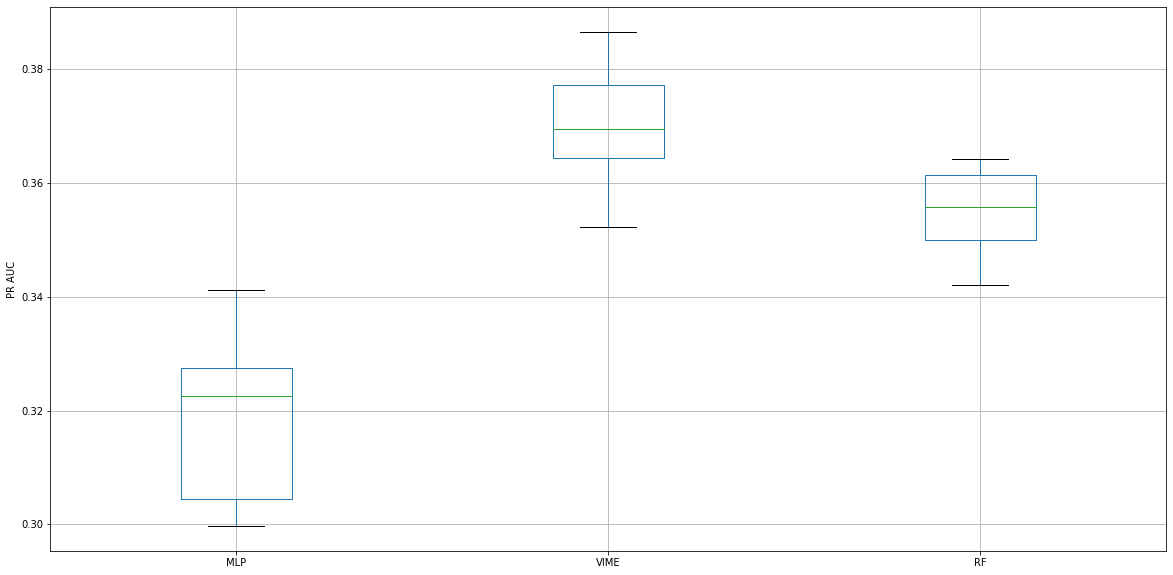

In [235]:
metrics_df = pd.DataFrame({"MLP": mlp_prs,
             "VIME": vime_prs,
             "RF": rf_prs})

metrics_df.boxplot()
plt.ylabel("PR AUC")
plt.show()

In [236]:
metrics_df.describe()

,MLP,VIME,RF
count,10.000000,10.000000,10.000000
mean,0.318847,0.370264,0.354883
std,0.014776,0.010052,0.007481
min,0.299667,0.352266,0.341996
25%,0.304485,0.364469,0.349961
50%,0.322631,0.369486,0.355842
75%,0.327522,0.377327,0.361452
max,0.341173,0.386599,0.364158
